# Working with index

## Content
* [Index types](#Index-types)
* [How to create an index](#How-to-create-an-index)
    * [from SEGY files](#from-SEGY-files)
    * [from SPS files](#from-SPS-files)
* [Conversion between types](#Conversion-between-types)
* [Merge](#Merge)

## Index types

There are 4 basic types of indices:
* ```FieldIndex``` enumerates field records
* ```SegyFilesIndex``` enumerates SEGY files
* ```TraceIndex``` enumerates traces
* ```BinsIndex``` enumerated bins of regular grid

and ```CustomIndex``` that enables enumeration on a basis of any ```segyio.TraceField``` attribute, e.g. ```INLINE_3D``` or ```ShotPoint```.

Each index contains basic SEGY trace headers: ```FieldRecord```, ```TraceNumber``` and ```TRACE_SEQUENCE_FILE```. Addinional headers depend on index type and on requisted extra headers.

There is an easy convertion between index types. Let ```index``` be an instance of some intex type, then  ```FieldIndex(index)``` will be an instance of type ```FieldIndex```, while ```TraceIndex(index)``` will be an instance of type ```TraceIndex``` etc.

Index can be created from a single SEGY file, from multiple SEGY files, from SPS files. Several indices can be merged together. Below we illustrate these options. 

## How to create an index

### from SEGY files

```FieldIndex```, ```TraceIndex```, ```SegyFilesIndex``` allow enumeration of traces, correspondong field records and additional metadata contained in set of SEGY files. For example, let's create an index of traces recorded a single segy file and include additional ```offset``` header:

In [1]:
import sys
import pandas as pd
import numpy as np

sys.path.append('..')
from geolog.src import FieldIndex, TraceIndex, SegyFilesIndex, BinsIndex, CustomIndex, SeismicBatch
from geolog.batchflow import Dataset

path_raw = '/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy'

index_raw = TraceIndex(name='raw', extra_headers=['offset'], path=path_raw)

```head()``` attribute (similar to pandas) shows 5 first traces:

In [2]:
index_raw.head()

,TraceNumber,offset,FieldRecord,TRACE_SEQUENCE_FILE,file_id
,,,,raw,raw
0,1656,35,111906,1,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
1,1657,36,111906,2,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
2,1655,78,111906,3,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
3,1658,79,111906,4,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
4,1654,127,111906,5,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy


In the next example we will create an index of traces from all SEGY files in a directory. Note that SEGY files may contain auxiliary traces, they can be dropped by ```drop_duplicates``` method:

In [3]:
path_segy = '/notebooks/egor/2D_Valyton/prof_37/segy/*.sgy'

index_segy = (FieldIndex(name='raw', path=path_segy)
              .drop_duplicates(subset=[('FieldRecord', ''), ('TraceNumber', '')], keep='last'))
index_segy.head()

,TraceNumber,TRACE_SEQUENCE_FILE,file_id
,,raw,raw
FieldRecord,,,
354,1,3,/notebooks/egor/2D_Valyton/prof_37/segy/000003...
354,2,4,/notebooks/egor/2D_Valyton/prof_37/segy/000003...
354,3,5,/notebooks/egor/2D_Valyton/prof_37/segy/000003...
354,4,6,/notebooks/egor/2D_Valyton/prof_37/segy/000003...
354,5,7,/notebooks/egor/2D_Valyton/prof_37/segy/000003...


Besides ```FieldIndex```, ```TraceIndex``` and ```SegyFilesIndex``` that enumerate field records, traces or files, it is possible to create a custom index on a basis of any ```segyio.TraceField``` attribute, e.g. ```INLINE_3D```, ```ShotPoint```, ```CDP``` etc. For example, let's crate an index of shot points:

In [5]:
index_shot = CustomIndex(name='raw', index_name='ShotPoint', path=path_raw)

index_shot.head()

,FieldRecord,TraceNumber,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw
ShotPoint,,,,
42000,111906,1656,1,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
42000,111906,1657,2,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
42000,111906,1655,3,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
42000,111906,1658,4,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
42000,111906,1654,5,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy


### from SPS files

```TraceIndex``` and ```FieldIndex``` can be alternatively constructed from SPS files. As a by-product, it will indlude offsets and a number of other metadata: 

In [6]:
dfx = pd.read_csv('/notebooks/egor/2D_Valyton/sps/ALL_VALUNT0910_X37.csv')
dfr = pd.read_csv('/notebooks/egor/2D_Valyton/sps/ALL_VALUNT0910_R_utm.csv')
dfs = pd.read_csv('/notebooks/egor/2D_Valyton/sps/ALL_VALUNT0910_S_utm.csv')

index_sps = FieldIndex(dfx=dfx, dfr=dfr, dfs=dfs)
index_sps.head()

,sline,sid,rline,rid,TraceNumber,point_index,sht_depth,uphole,x_s,y_s,z_s,x_r,y_r,z_r,offset
,,,,,,,,,,,,,,,
FieldRecord,,,,,,,,,,,,,,,
481,S37,1011,R37,101,1,1,18.0,8.0,338283.90,7026994.0,70.0,338283.9,7026994.0,70.0,0.000000
480,S37,1031,R37,101,1,1,18.0,8.0,338288.62,7027043.5,69.9,338283.9,7026994.0,70.0,24.862263
479,S37,1051,R37,101,1,1,18.0,9.0,338293.30,7027093.5,69.8,338283.9,7026994.0,70.0,49.971517
478,S37,1071,R37,101,1,1,18.0,9.0,338298.00,7027143.0,69.7,338283.9,7026994.0,70.0,74.832830
477,S37,1091,R37,101,1,1,18.0,8.0,338302.70,7027193.0,69.6,338283.9,7026994.0,70.0,99.943034


To create a ```Binsindex``` one should specify ```bin_size```. During index construction an optimal grid position will be searched: 

In [7]:
dfx = pd.read_csv('/notebooks/egor/Xfield/Xfield_X.csv')
dfr = pd.read_csv('/notebooks/egor/Xfield/Xfield_R.csv')
dfs = pd.read_csv('/notebooks/egor/Xfield/Xfield_S.csv')

bin_size = 1000

index_bin = BinsIndex(dfr=dfr, dfs=dfs, dfx=dfx, bin_size=(bin_size, bin_size), iters=10)
index_bin.head()

,FieldRecord,sline,sid,rline,rid,TraceNumber,x_s,y_s,z_s,x_r,y_r,z_r,x_cdp,y_cdp,az,offset
,,,,,,,,,,,,,,,,
bin_id,,,,,,,,,,,,,,,,
25/5,228691Z,S2105,5139,R5103,2049,1,493989.9,6608026.0,38.7,491215.7,6606201.5,41.4,492602.8,6607113.75,-2.559846,1660.194709
25/5,228671Z,S2105,5140,R5103,2049,1,493989.9,6608076.0,38.6,491215.7,6606201.5,41.4,492602.8,6607138.75,-2.547369,1674.062117
25/5,228651Z,S2105,5141,R5103,2049,1,493989.9,6608126.0,38.6,491215.7,6606201.5,41.4,492602.8,6607163.75,-2.535098,1688.185852
25/5,228631Z,S2105,5142,R5103,2049,1,493989.9,6608175.5,38.6,491215.7,6606201.5,41.4,492602.8,6607188.50,-2.523153,1702.414582
25/5,228611Z,S2105,5143,R5103,2049,1,493989.9,6608226.0,38.7,491215.7,6606201.5,41.4,492602.8,6607213.75,-2.511172,1717.176890


The heatmap shows a distribution of traces within bins:

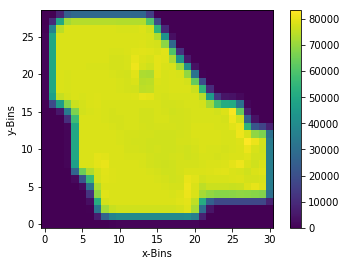

In [8]:
index_bin.show_heatmap()

## Conversion between types

Indices can be easily converted to each other type. For example, ```FieldIndex``` to ```TraceIndex```:

In [9]:
SegyFilesIndex(index_segy, name='raw').head()

,FieldRecord,TraceNumber,TRACE_SEQUENCE_FILE
,,,raw
"(file_id, raw)",,,
/notebooks/egor/2D_Valyton/prof_37/segy/00000354_f1.r354.sgy,354,1,3
/notebooks/egor/2D_Valyton/prof_37/segy/00000354_f1.r354.sgy,354,2,4
/notebooks/egor/2D_Valyton/prof_37/segy/00000354_f1.r354.sgy,354,3,5
/notebooks/egor/2D_Valyton/prof_37/segy/00000354_f1.r354.sgy,354,4,6
/notebooks/egor/2D_Valyton/prof_37/segy/00000354_f1.r354.sgy,354,5,7


or vise-versa:

In [10]:
FieldIndex(index_raw).head()

,TraceNumber,offset,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw
FieldRecord,,,,
111906,1656,35,1,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,1657,36,2,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,1655,78,3,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,1658,79,4,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,1654,127,5,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy


or ```BinsIndex``` to ```FieldIndex```:

In [11]:
FieldIndex(index_bin).head()

,bin_id,sline,sid,rline,rid,TraceNumber,x_s,y_s,z_s,x_r,y_r,z_r,x_cdp,y_cdp,az,offset
,,,,,,,,,,,,,,,,
FieldRecord,,,,,,,,,,,,,,,,
228691Z,25/5,S2105,5139,R5103,2049,1,493989.9,6608026.0,38.7,491215.7,6606201.5,41.4,492602.8,6607113.75,-2.559846,1660.194709
228671Z,25/5,S2105,5140,R5103,2049,1,493989.9,6608076.0,38.6,491215.7,6606201.5,41.4,492602.8,6607138.75,-2.547369,1674.062117
228651Z,25/5,S2105,5141,R5103,2049,1,493989.9,6608126.0,38.6,491215.7,6606201.5,41.4,492602.8,6607163.75,-2.535098,1688.185852
228631Z,25/5,S2105,5142,R5103,2049,1,493989.9,6608175.5,38.6,491215.7,6606201.5,41.4,492602.8,6607188.50,-2.523153,1702.414582
228611Z,25/5,S2105,5143,R5103,2049,1,493989.9,6608226.0,38.7,491215.7,6606201.5,41.4,492602.8,6607213.75,-2.511172,1717.176890


or custom shot index for ```FieldIndex```:

In [12]:
FieldIndex(index_shot).head()

,ShotPoint,TraceNumber,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw
FieldRecord,,,,
111906,42000,1656,1,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,42000,1657,2,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,42000,1655,3,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,42000,1658,4,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,42000,1654,5,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy


## Merge

Two index instances can be merged on common headers. For example, ```index_segy``` does not contain offsets. However, we can merge it with ```index_sps``` that includes offsets:

In [13]:
index_segy = index_segy.merge(index_sps)
index_segy.head()

,TraceNumber,TRACE_SEQUENCE_FILE,file_id,sline,sid,rline,rid,point_index,sht_depth,uphole,x_s,y_s,z_s,x_r,y_r,z_r,offset
,,raw,raw,,,,,,,,,,,,,,
FieldRecord,,,,,,,,,,,,,,,,,
354,1,3,/notebooks/egor/2D_Valyton/prof_37/segy/000003...,S37,3591,R37,219,1,18.0,14.0,338886.78,7033413.0,71.5,338560.00,7029929.5,76.0,1749.396855
354,2,4,/notebooks/egor/2D_Valyton/prof_37/segy/000003...,S37,3591,R37,220,1,18.0,14.0,338886.78,7033413.0,71.5,338562.40,7029954.5,76.1,1736.839416
354,3,5,/notebooks/egor/2D_Valyton/prof_37/segy/000003...,S37,3591,R37,221,1,18.0,14.0,338886.78,7033413.0,71.5,338564.70,7029979.5,76.2,1724.286648
354,4,6,/notebooks/egor/2D_Valyton/prof_37/segy/000003...,S37,3591,R37,222,1,18.0,14.0,338886.78,7033413.0,71.5,338567.00,7030004.5,76.8,1711.733880
354,5,7,/notebooks/egor/2D_Valyton/prof_37/segy/000003...,S37,3591,R37,223,1,18.0,14.0,338886.78,7033413.0,71.5,338569.38,7030029.0,77.4,1699.426283


Now we can load traces sorted by offset:

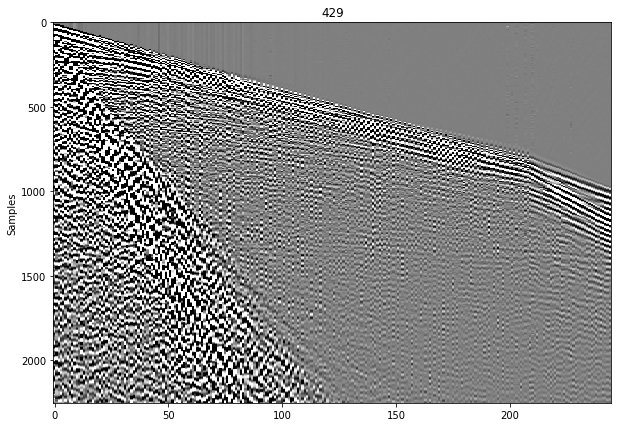

In [14]:
cv = 1

batch = (Dataset(index_segy, SeismicBatch).next_batch(50)
         .load(components='raw', sort_by='offset'))

batch.show_traces('raw', batch.indices[20], figsize=(10, 7),
                  vmin=-cv, vmax=cv, cmap='gray')

Enjoy!